In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
plt.style.use('fivethirtyeight')
plt.style.use('seaborn-poster')

In [3]:
# From Covid Tracking API
# https://covidtracking.com/api/
api_us = 'https://covidtracking.com/api/us/daily'
api_states = 'https://covidtracking.com/api/states/daily'

# https://github.com/COVID19Tracking/associated-data
f_pop = 'associated-data/us_census_data/us_census_2018_population_estimates_states.csv'

In [4]:
df_us = pd.read_json(api_us)
df_states = pd.read_json(api_states)
df_pop = pd.read_csv(f_pop)

In [5]:
df_us.shape

(36, 24)

In [6]:
df_states.shape

(1877, 25)

In [7]:
df_pop.head()

,state,state_name,geo_id,population,pop_density
0,AL,Alabama,1,4887871,96.509389
1,AK,Alaska,2,737438,1.291523
2,AZ,Arizona,4,7171646,63.135855
3,AR,Arkansas,5,3013825,57.919684
4,CA,California,6,39557045,253.906502


In [8]:
df_us['date'] = df_us['date'].apply(
    lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
df_states['date'] = df_states['date'].apply(
    lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

In [9]:
df_us.sort_values(by=['date']).tail()

,date,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
4,2020-04-04,56,305755,1318592,15573,22158.0,38211.0,5207.0,587.0,656.0,...,8314,38211.0,1639920,1624347,1624347,1352.0,4071.0,193718.0,33767.0,227485.0
3,2020-04-05,56,332308,1429724,17307,23061.0,41062.0,5497.0,762.0,612.0,...,9498,41062.0,1779339,1762032,1762032,1184.0,2851.0,111132.0,26553.0,137685.0
2,2020-04-06,56,361331,1547026,17292,27847.0,44850.0,6607.0,816.0,2921.0,...,10680,44850.0,1925649,1908357,1908357,1182.0,3788.0,117302.0,29023.0,146325.0
1,2020-04-07,56,392594,1661868,16557,39011.0,45580.0,9649.0,889.0,4007.0,...,12621,45580.0,2071019,2054462,2054462,1941.0,730.0,114842.0,31263.0,146105.0
0,2020-04-08,56,423164,1766602,17228,43524.0,47159.0,9702.0,1013.0,4073.0,...,14495,47159.0,2206994,2189766,2189766,1874.0,1579.0,104734.0,30570.0,135304.0


In [10]:
df_states.sort_values(by=['date']).tail()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
32,2020-04-08,NE,519.0,7442.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,7961,7961,7961,31,2.0,0.0,631.0,72.0,703.0
31,2020-04-08,ND,251.0,8301.0,NaN,16.0,34.0,NaN,NaN,NaN,...,34.0,8552,8552,8552,38,0.0,1.0,835.0,14.0,849.0
30,2020-04-08,NC,3426.0,39561.0,NaN,386.0,NaN,NaN,NaN,NaN,...,NaN,42987,42987,42987,37,7.0,0.0,1700.0,205.0,1905.0
28,2020-04-08,MS,2003.0,18632.0,NaN,NaN,410.0,NaN,NaN,NaN,...,410.0,20635,20635,20635,28,8.0,33.0,0.0,88.0,88.0
0,2020-04-08,AK,226.0,6842.0,NaN,NaN,27.0,NaN,NaN,NaN,...,27.0,7068,7068,7068,2,1.0,4.0,142.0,13.0,155.0


In [11]:
# Merge in population data
df_states = pd.merge(df_states, df_pop, on='state')

# Calculate positive per 100,000
df_states['pos_rate'] = df_states['positive'] / (df_states['population'] / 1e5)

# Calculate hospitalized per 100,000
df_states['hosp_rate'] = df_states['hospitalized'] / (df_states['population'] / 1e5)

# Calculate deaths per 100,000
df_states['death_rate'] = df_states['death'] / (df_states['population'] / 1e5)

# Calculate total tests
df_states['total'] = df_states['positive'] + df_states['negative']

# Calculate percent of tests that are positive
df_states['positive_rate'] = df_states['positive'] / df_states['total']

# Calculate tests per 100,000 people
df_states['test_rate'] = df_states['total'] / (df_states['population'] / 1e5)

# Calculate 7-day average deaths
df_states['death_7dma'] = df_states['death'].rolling(window=7).mean()

In [12]:
df_states.tail()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,state_name,geo_id,population,pop_density,pos_rate,hosp_rate,death_rate,positive_rate,test_rate,death_7dma
1776,2020-03-11,WY,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Wyoming,56,577737,5.950611,0.0,NaN,NaN,NaN,NaN,NaN
1777,2020-03-10,WY,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,Wyoming,56,577737,5.950611,0.0,NaN,NaN,NaN,0.0,NaN
1778,2020-03-09,WY,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Wyoming,56,577737,5.950611,0.0,NaN,NaN,NaN,NaN,NaN
1779,2020-03-08,WY,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Wyoming,56,577737,5.950611,0.0,NaN,NaN,NaN,NaN,NaN
1780,2020-03-07,WY,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Wyoming,56,577737,5.950611,0.0,NaN,NaN,NaN,NaN,NaN


In [13]:
df_states.describe()

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,...,totalTestResultsIncrease,geo_id,population,pop_density,pos_rate,hosp_rate,death_rate,positive_rate,test_rate,death_7dma
count,1781.000000,1676.000000,461.000000,223.000000,518.000000,60.000000,75.000000,69.000000,40.000000,213.000000,...,1729.000000,1781.000000,1.781000e+03,1757.000000,1781.000000,518.000000,1118.000000,1671.000000,1676.000000,812.000000
mean,2015.536216,9789.735084,1628.611714,1329.834081,809.436293,1059.166667,283.320000,239.724638,45.025000,591.840376,...,1265.229612,29.563728,6.505935e+06,428.608448,23.507204,7.057642,0.911963,0.125698,205.913463,68.289057
std,9241.947453,20445.894590,8749.336521,3235.344593,3526.692879,1365.158266,624.342598,354.970416,36.380107,2206.321587,...,3231.040137,16.356836,7.341799e+06,1598.885769,60.569705,17.940841,2.352107,0.136343,282.964009,275.639421
min,0.000000,0.000000,-3.000000,2.000000,0.000000,9.000000,6.000000,4.000000,6.000000,2.000000,...,-585.000000,1.000000,5.777370e+05,1.291523,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,14.000000,146.750000,5.000000,45.500000,29.000000,37.000000,9.000000,18.000000,6.000000,29.000000,...,22.000000,16.000000,1.805832e+06,54.955978,0.377811,1.475715,0.058089,0.048144,5.301267,3.571429
50%,151.000000,2177.500000,26.000000,113.000000,117.000000,627.000000,74.000000,31.000000,39.000000,62.000000,...,244.000000,29.000000,4.468402e+06,107.860112,4.594212,3.346989,0.265461,0.086142,74.042472,12.000000
75%,890.000000,10415.000000,140.000000,1080.000000,347.750000,1363.250000,180.500000,490.000000,49.500000,158.000000,...,1206.000000,42.000000,7.535591e+06,229.511156,23.148524,6.337810,0.756410,0.151774,318.188448,39.428571
max,149316.000000,215837.000000,64400.000000,18079.000000,32669.000000,4593.000000,3022.000000,1576.000000,108.000000,14590.000000,...,78400.000000,72.000000,3.955704e+07,11490.119540,764.069200,167.171480,32.074163,0.891705,1868.534924,4221.000000


## California

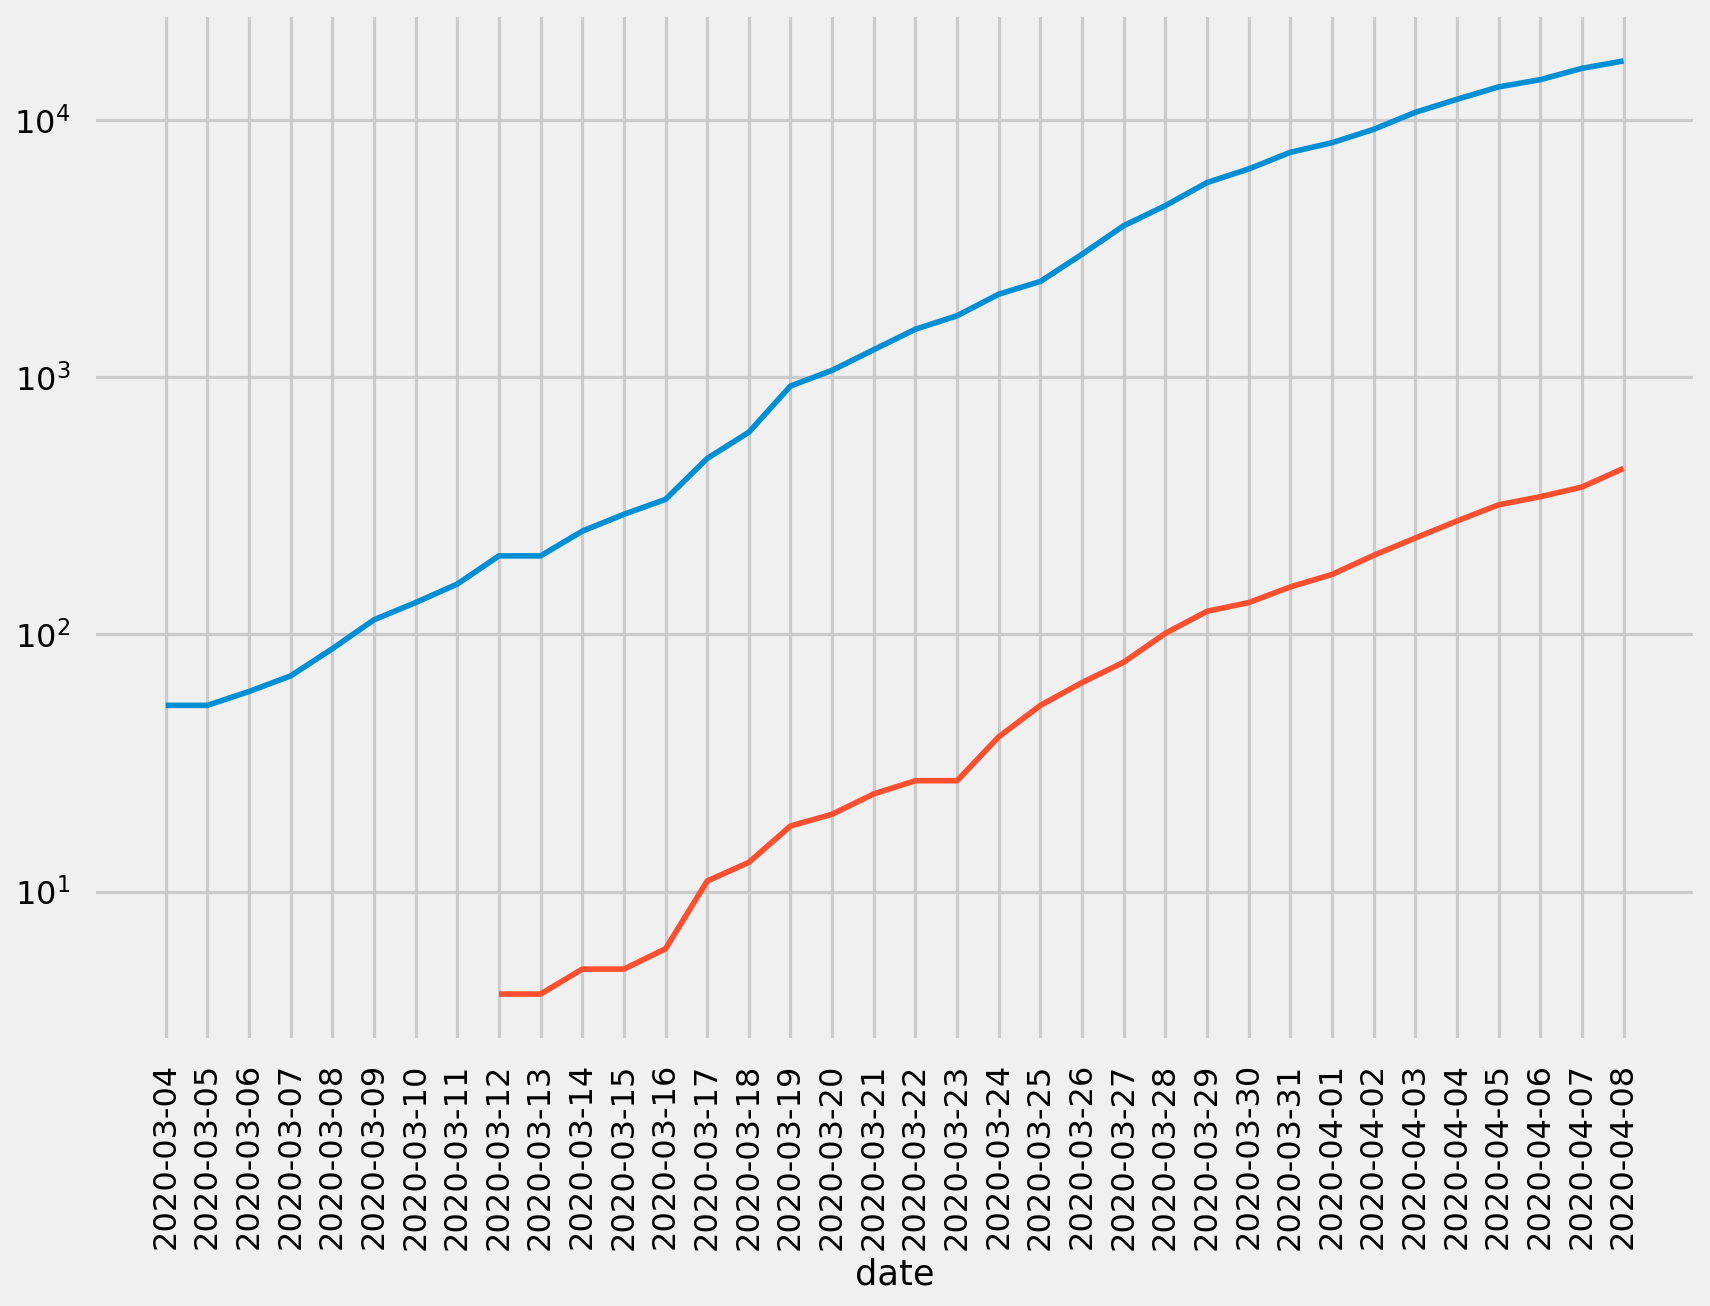

In [14]:
ax = sns.lineplot(x="date", y="positive", 
                  data=df_states.query('state == "CA"'))
ax = sns.lineplot(x="date", y="death", 
                  data=df_states.query('state == "CA"'))
ax.set(xticks=df_states.query('state == "CA"').date.values)
plt.xticks(rotation=90)
ax.set_ylabel('')
ax.set_yscale('log')
plt.show()

## New York

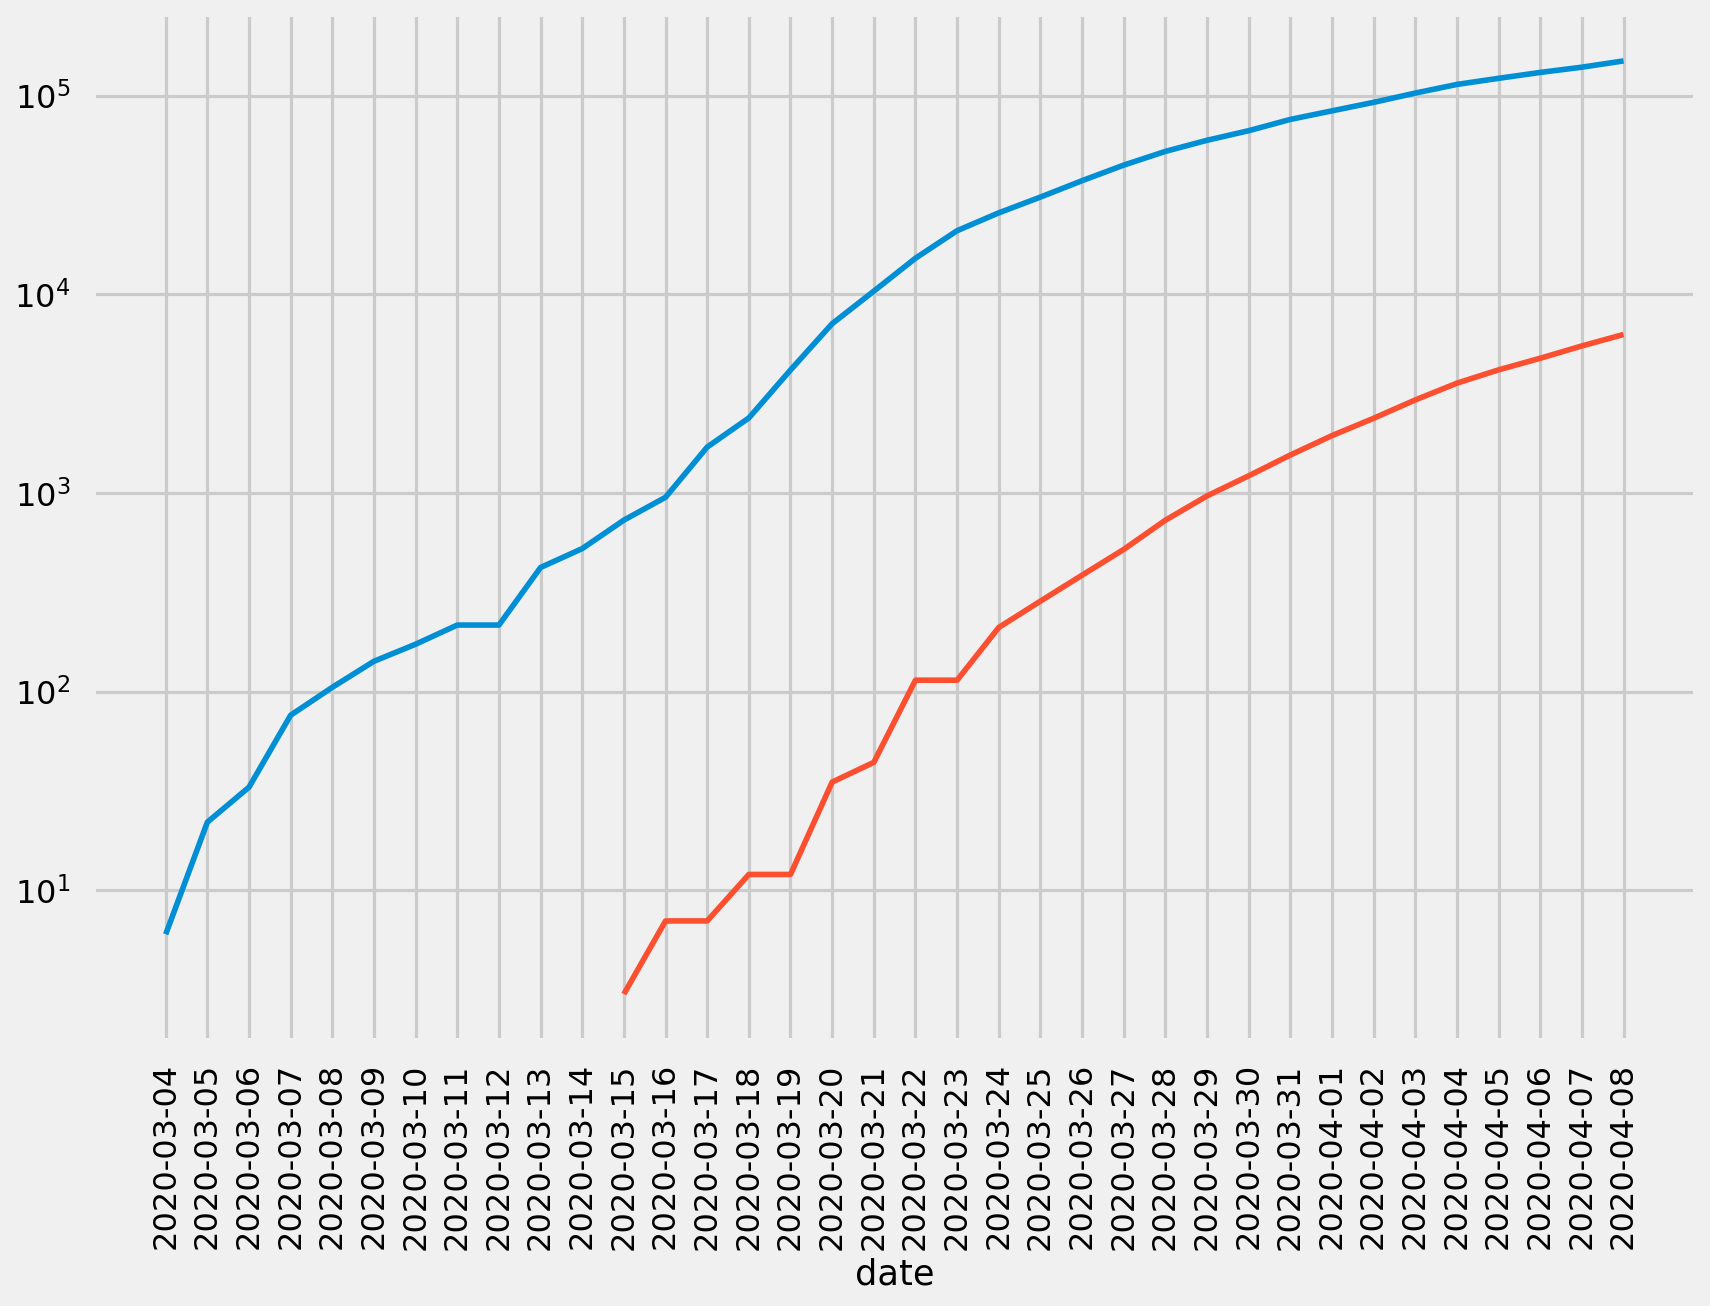

In [15]:
ax = sns.lineplot(x="date", y="positive", 
                  data=df_states.query('state == "NY"'))
ax = sns.lineplot(x="date", y="death", 
                  data=df_states.query('state == "NY"'))
ax.set(xticks=df_states.query('state == "NY"').date.values)
plt.xticks(rotation=90)
ax.set_ylabel('')
ax.set_yscale('log')
plt.show()

# Top 10 States by Deaths

In [16]:
latest_date = df_states['date'].max()
top_states = df_states.query('date == @latest_date').sort_values(by='death', 
                                                    ascending=False).state.head(10).tolist()
df_top_states = df_states.query('state == @top_states')
top_states

['NY', 'NJ', 'MI', 'LA', 'IL', 'CA', 'MA', 'WA', 'GA', 'PA']

In [17]:
df_states.query('date == @latest_date').sort_values(by='death', 
                                                    ascending=False)[['state', 'death']]

,state,death
1169,NY,6268.0
1065,NJ,1504.0
757,MI,959.0
620,LA,652.0
482,IL,462.0
137,CA,442.0
653,MA,433.0
1642,WA,394.0
346,GA,362.0
1309,PA,309.0


In [18]:
# Deaths per 100,000 people
df_states.query('date == @latest_date').sort_values(by='death_rate', 
                                                    ascending=False)[['state', 'death_rate']]

,state,death_rate
1169,NY,32.074163
1065,NJ,16.882715
620,LA,13.991482
757,MI,9.593919
208,CT,7.753316
653,MA,6.273408
1642,WA,5.228522
241,DC,3.843663
1608,VT,3.672367
482,IL,3.626066


# Deaths

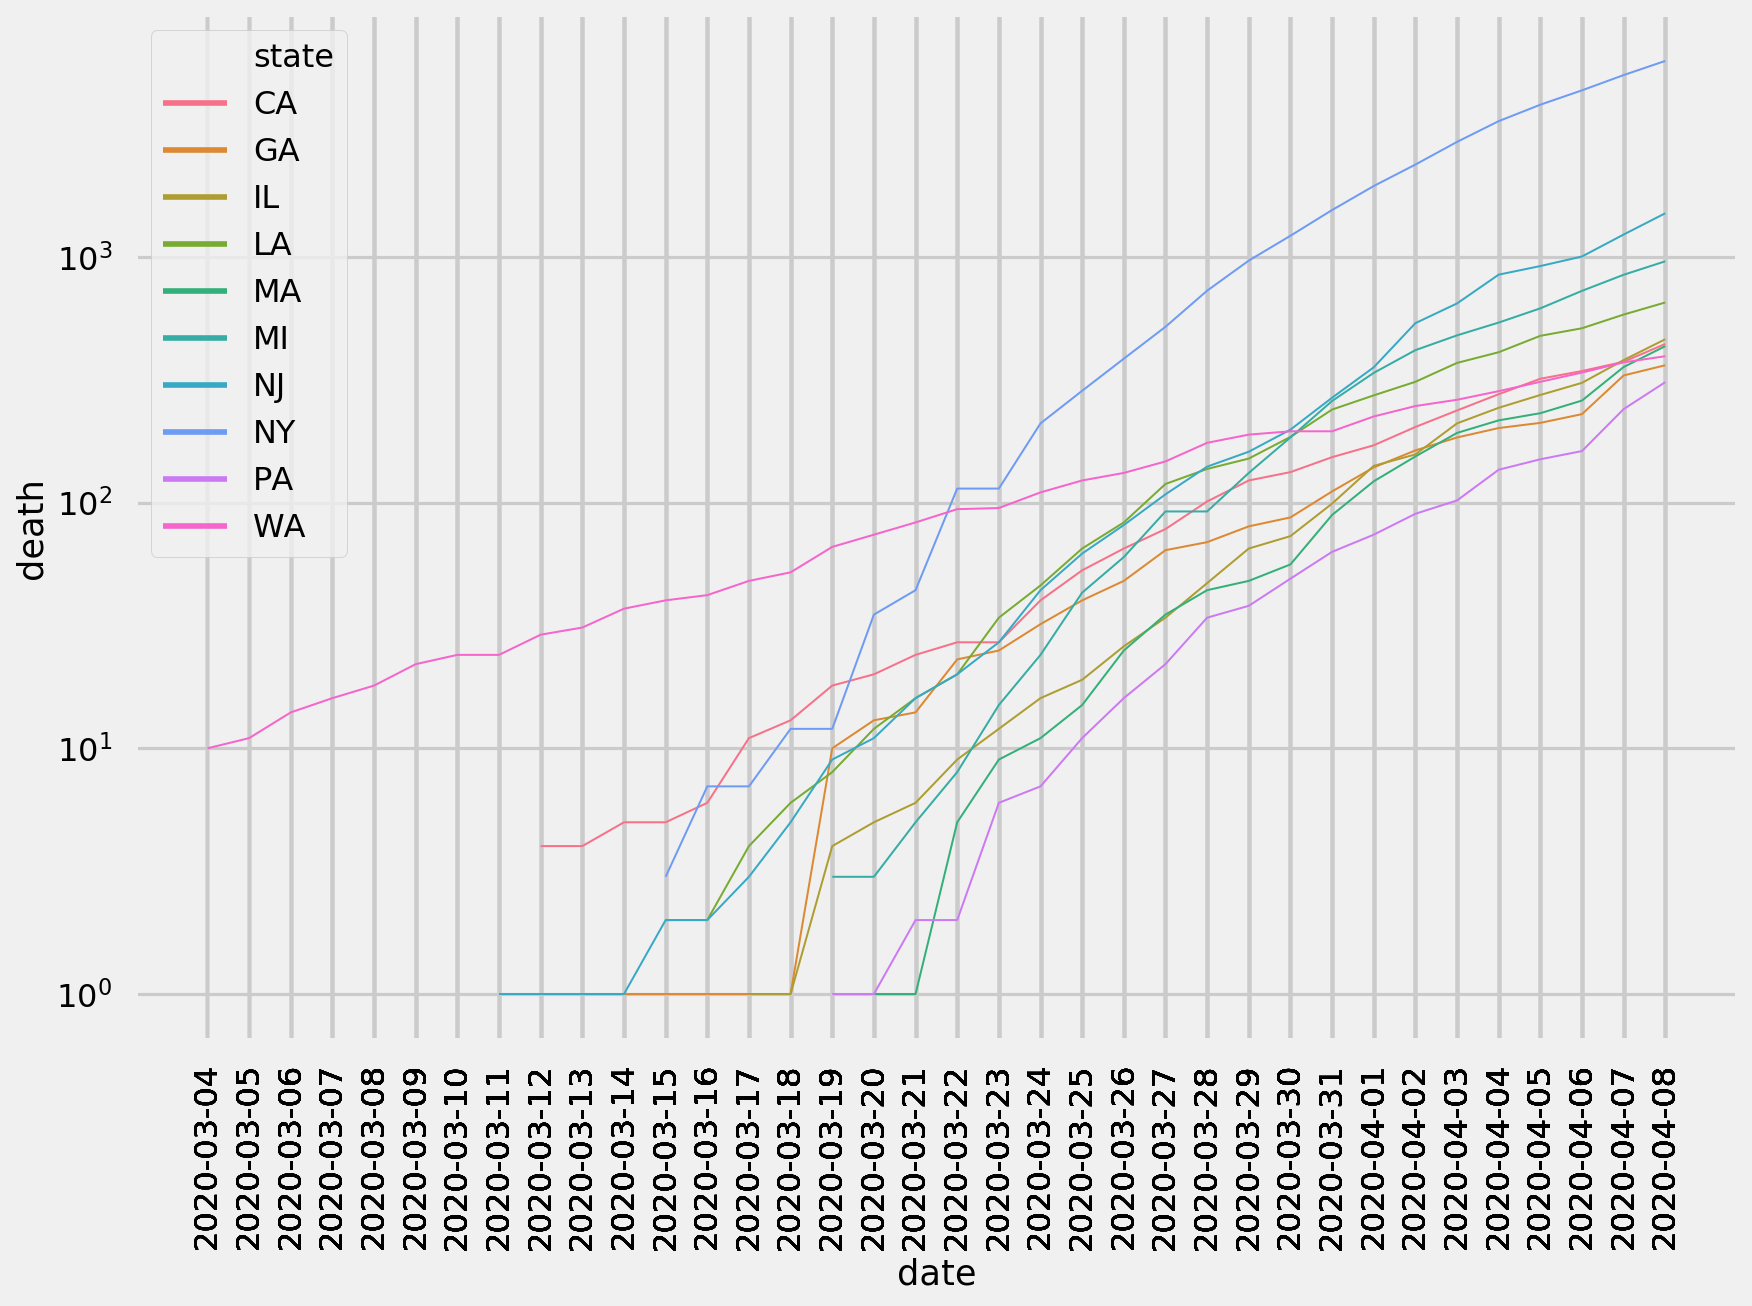

In [19]:
ax = sns.lineplot(x="date", 
                  y="death", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

# Deaths (7-day Moving Average)

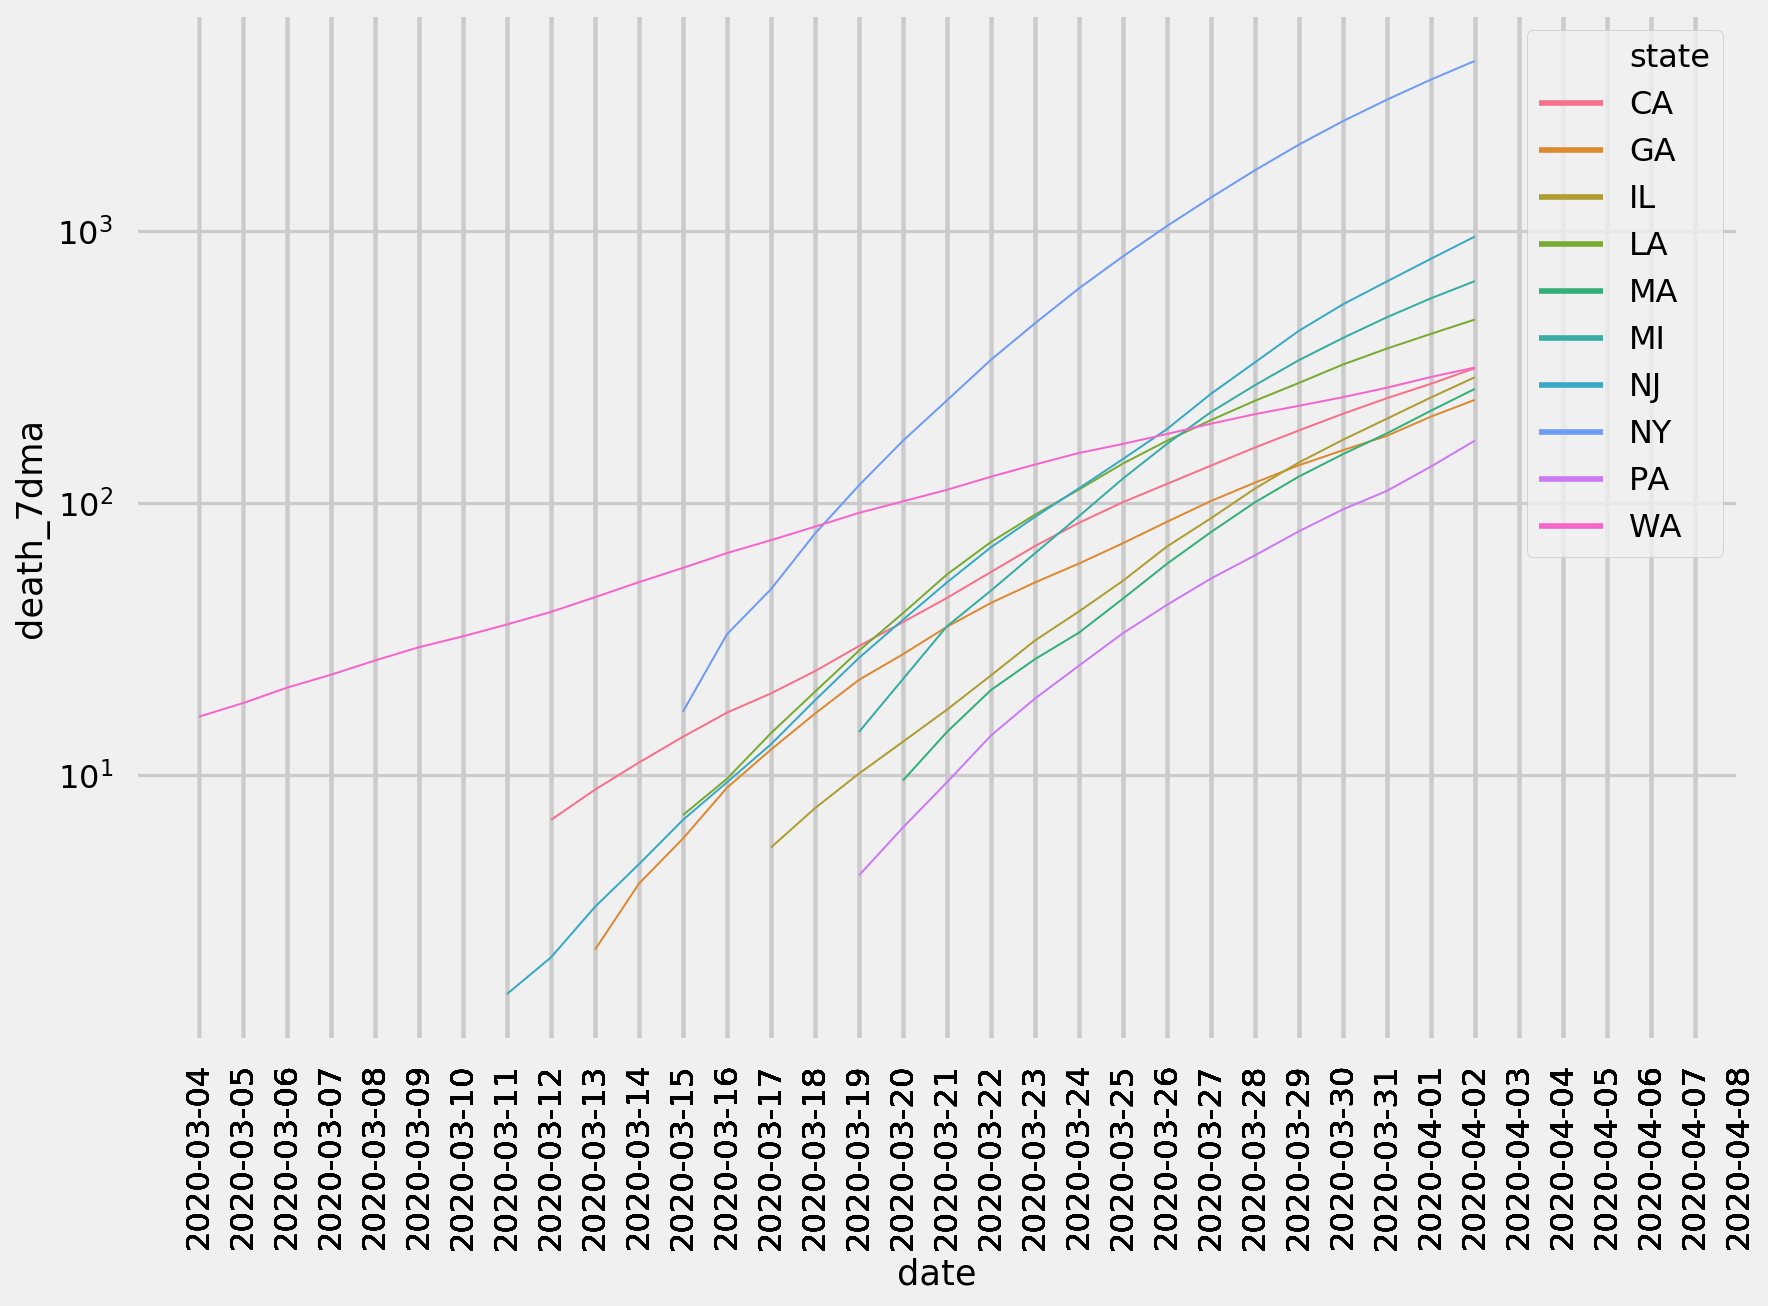

In [20]:
# TODO: index this by date first crossed 5 deaths
ax = sns.lineplot(x="date", 
                  y="death_7dma", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

# Positive Cases Per 100,000 People

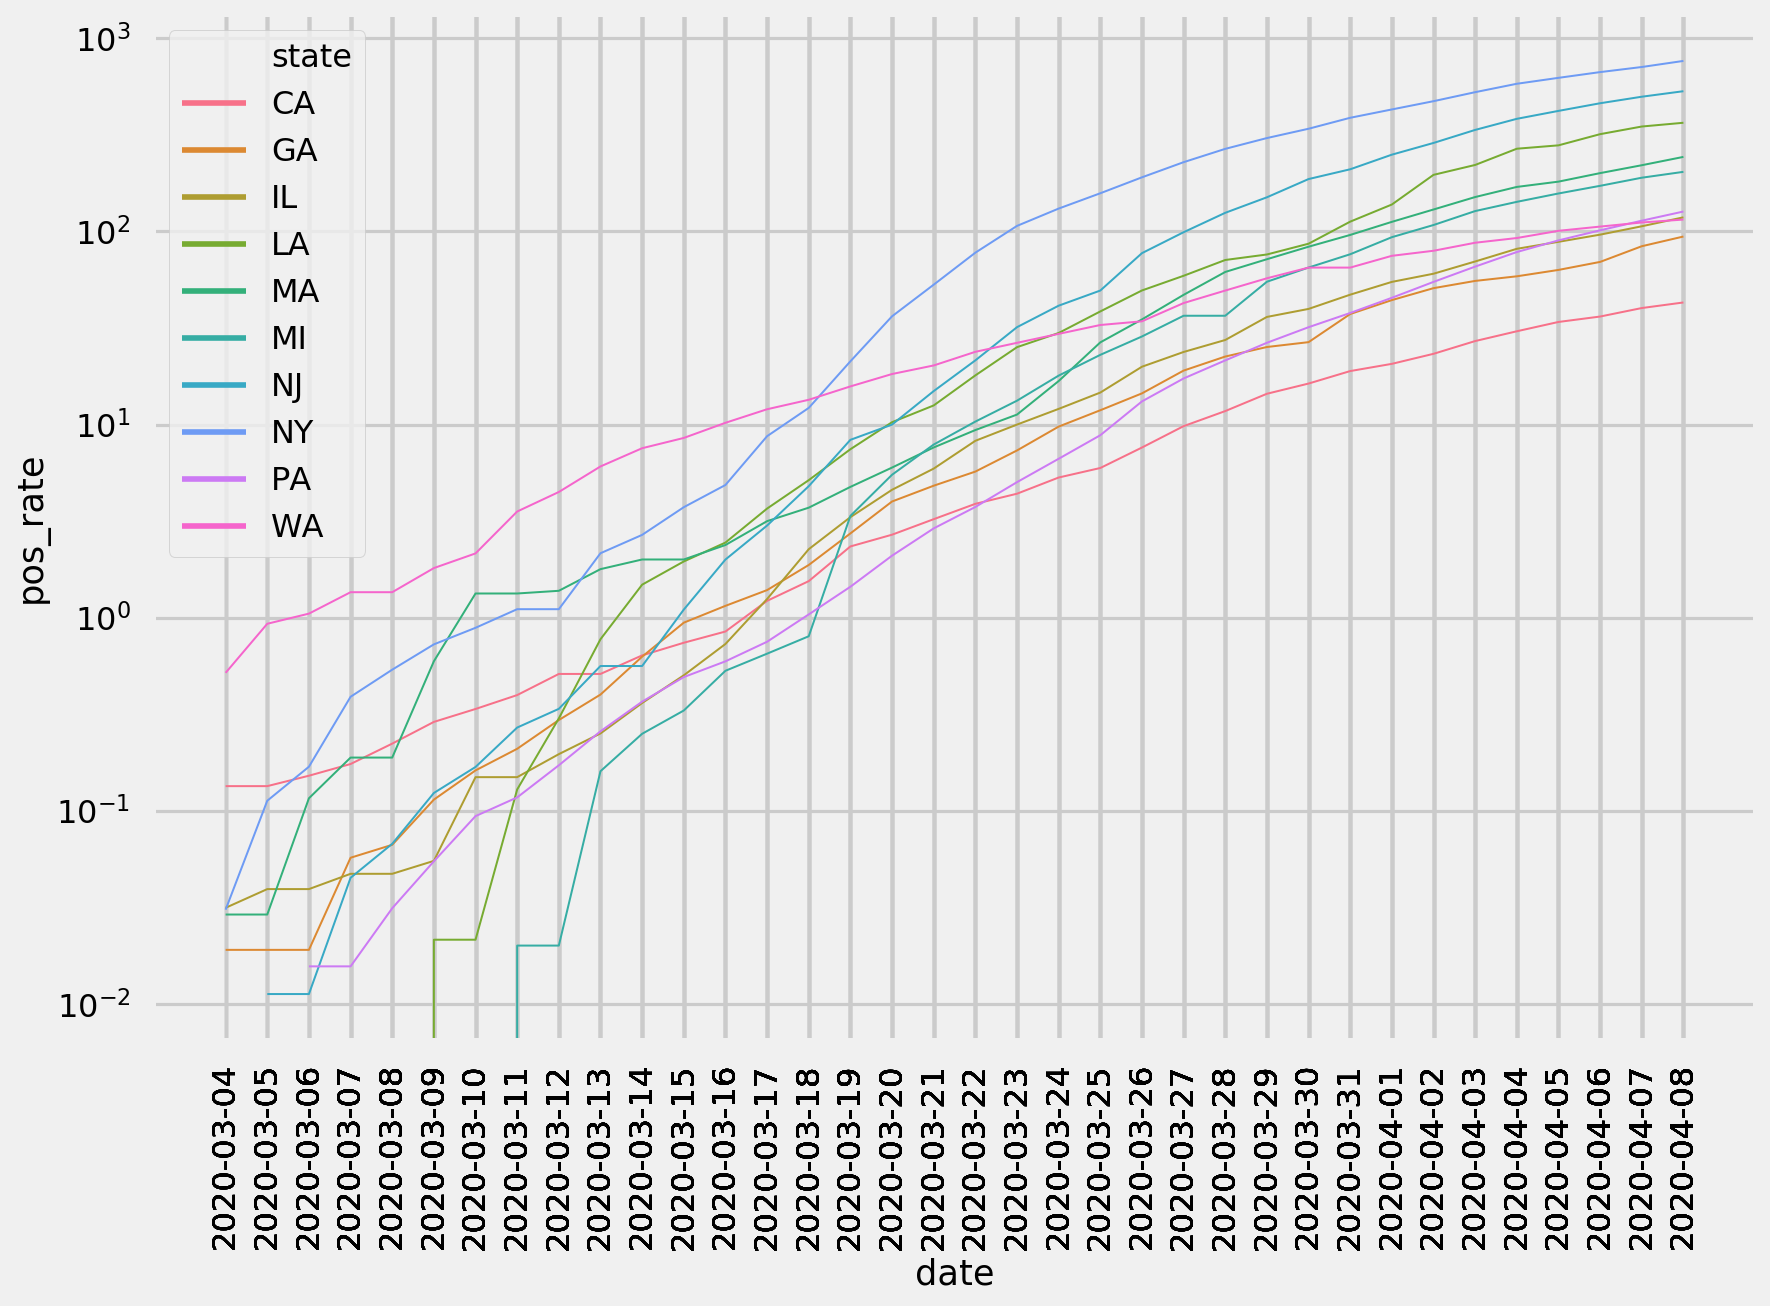

In [21]:
ax = sns.lineplot(x="date", y="pos_rate", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

# Deaths Per 100,000 People

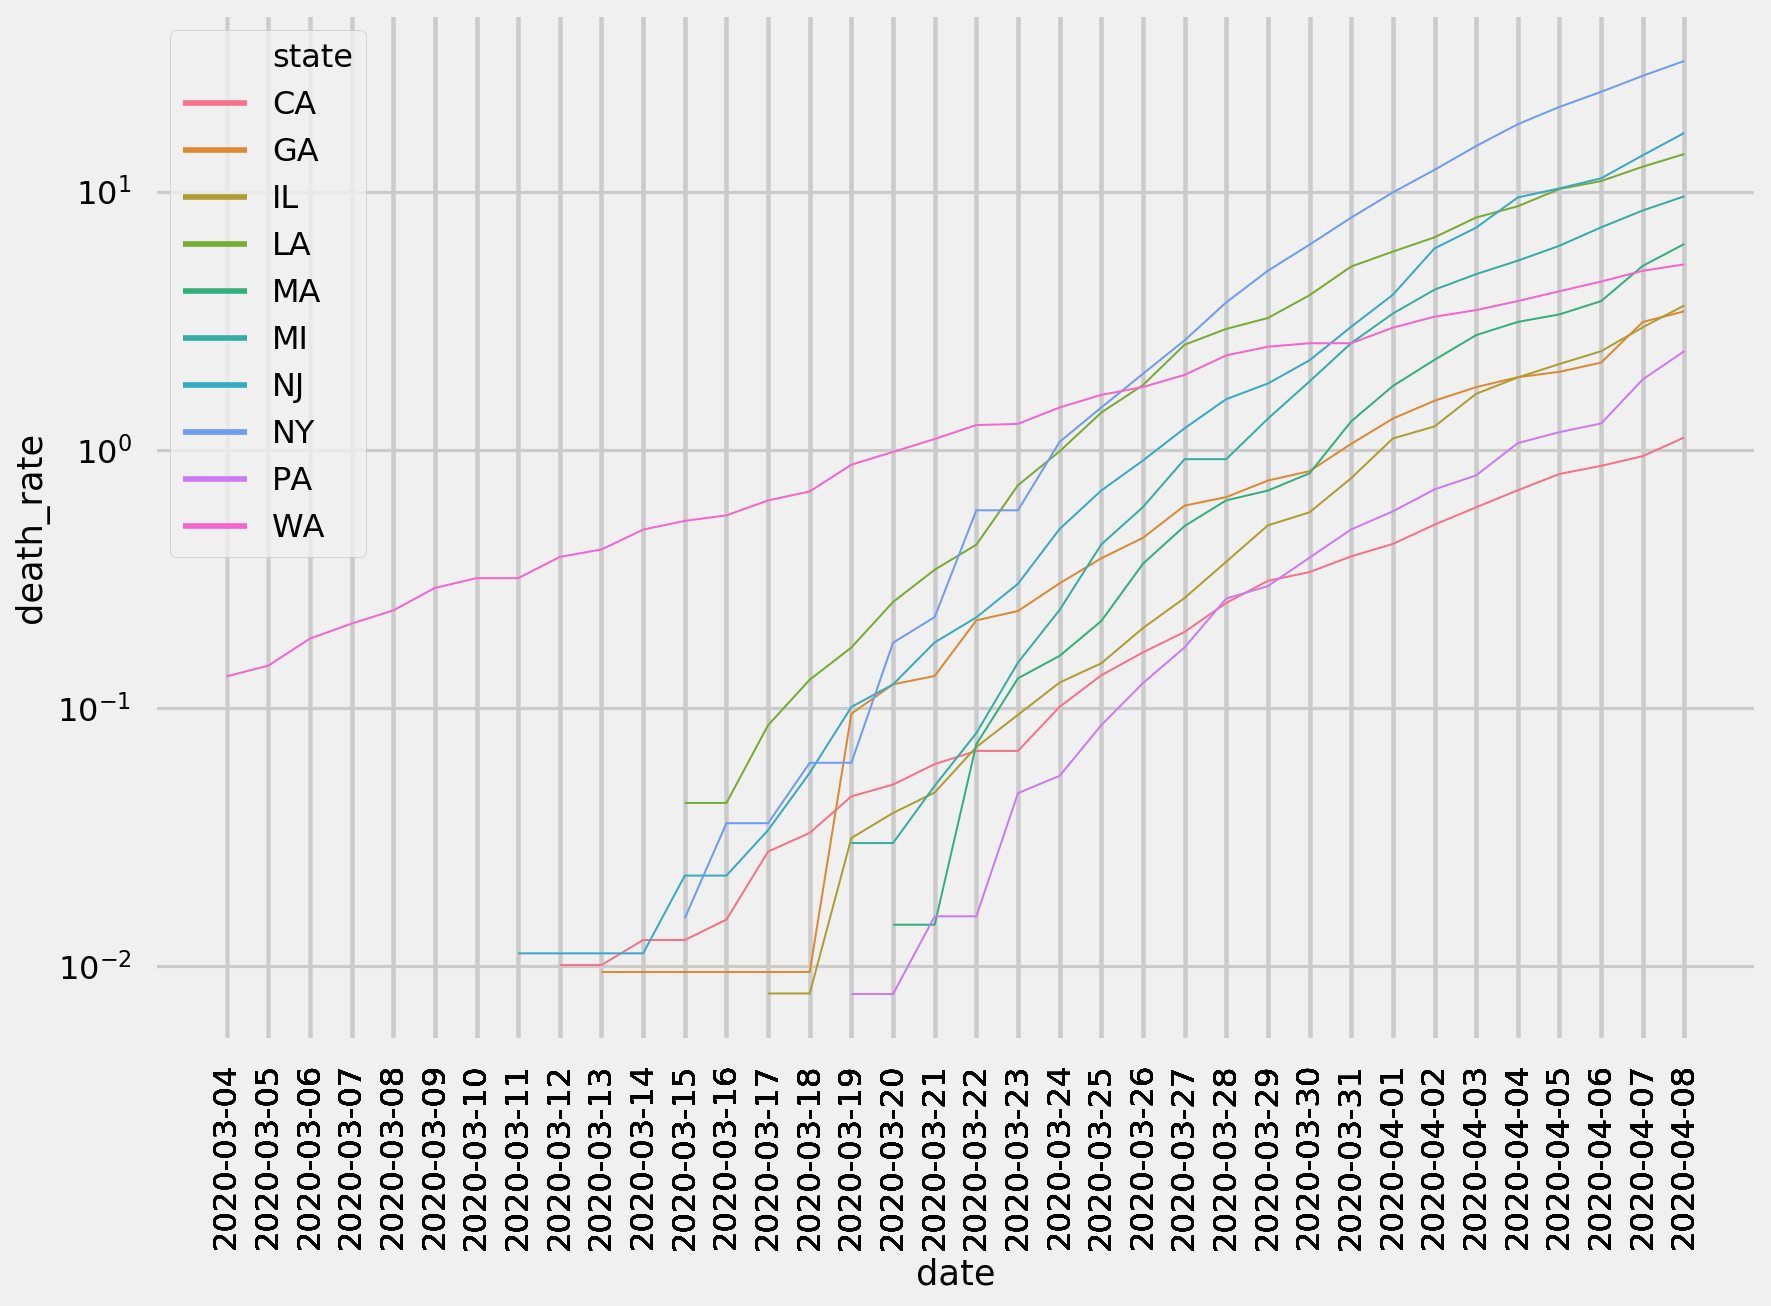

In [22]:
ax = sns.lineplot(x="date", y="death_rate", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

# Tests Per 100,000 People

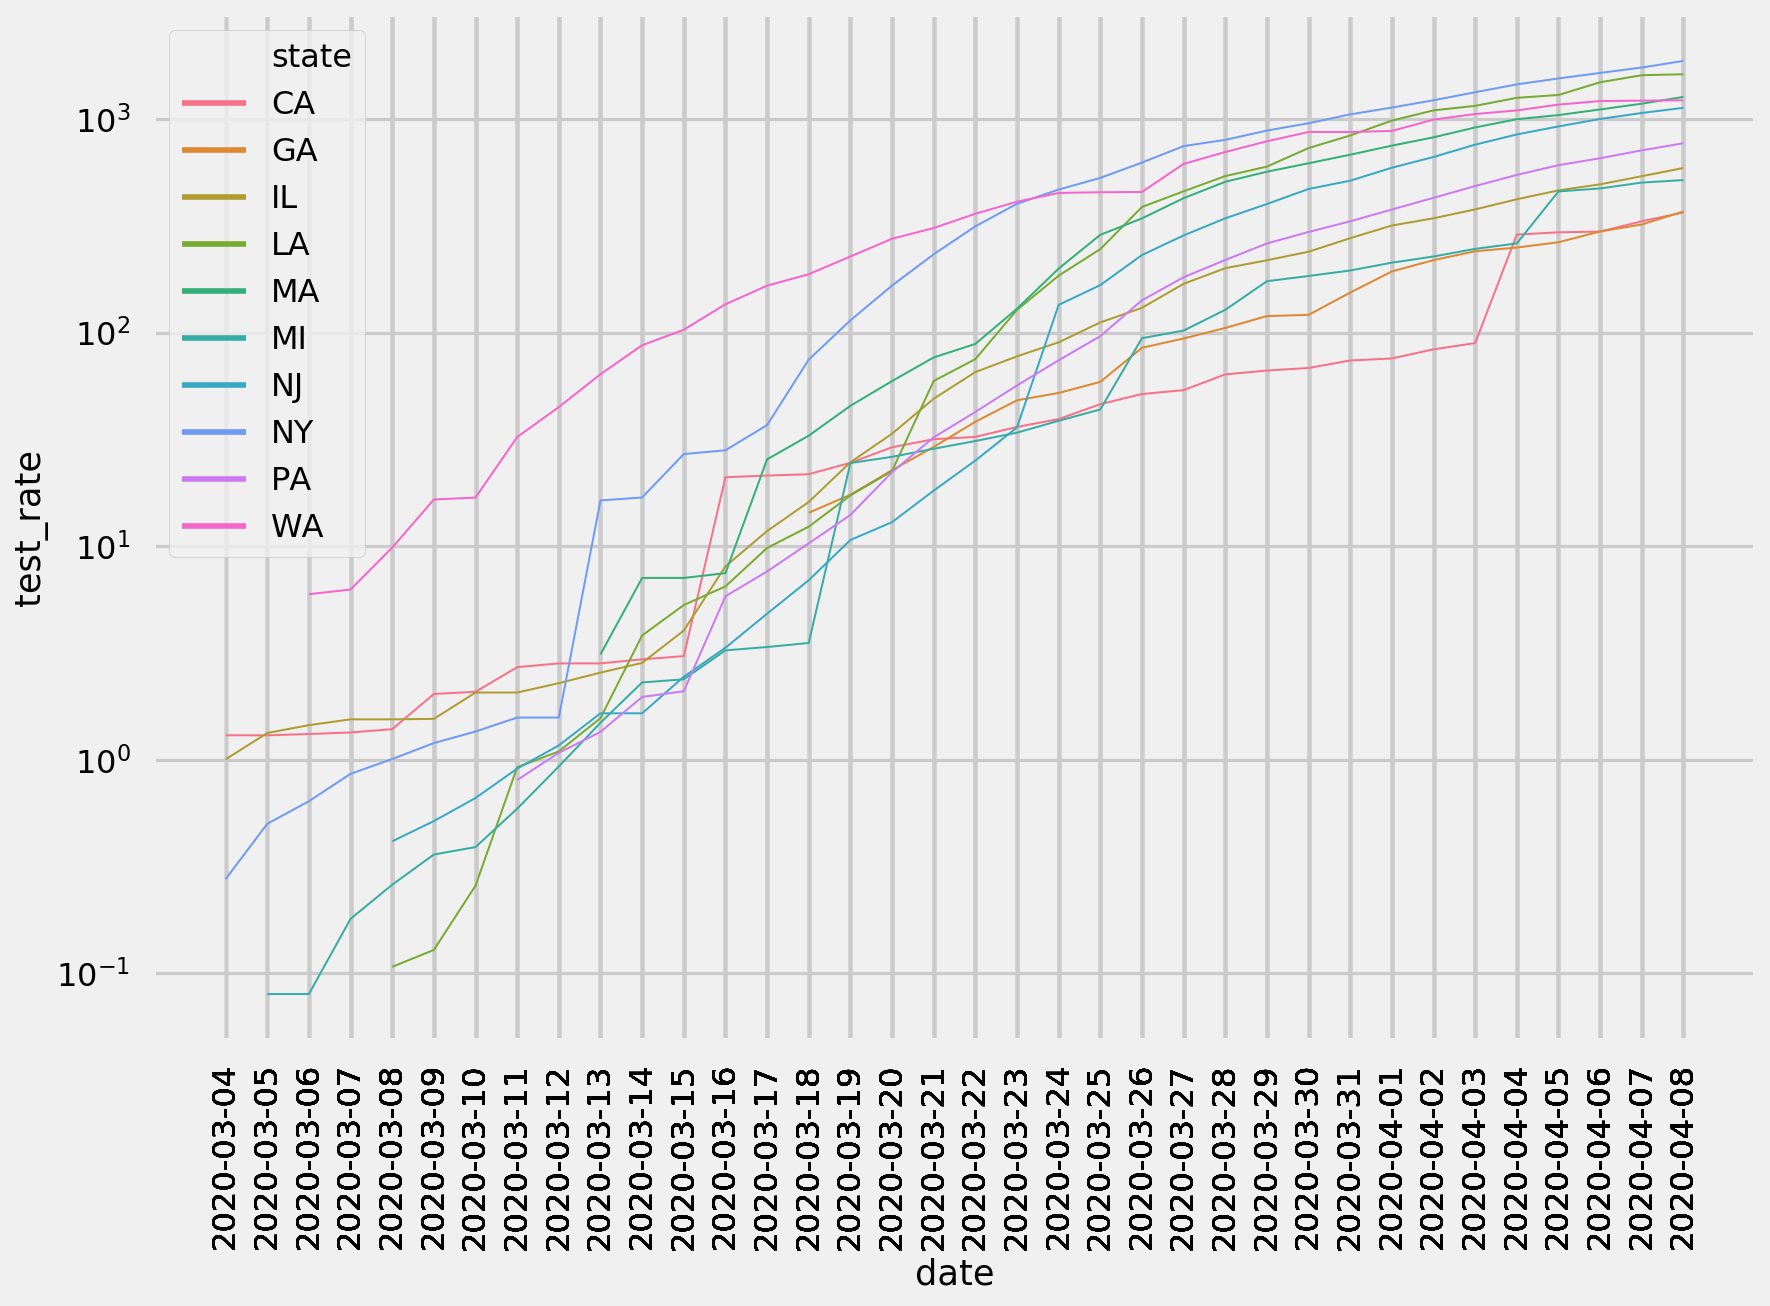

In [23]:
ax = sns.lineplot(x="date", y="test_rate", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

In [24]:
df_states.query('date == @latest_date').sort_values(by='test_rate', 
                                                    ascending=False)[['state', 'test_rate']]

,state,test_rate
1169,NY,1868.534924
620,LA,1618.054849
653,MA,1267.880482
1608,VT,1237.268461
1642,WA,1221.841791
241,DC,1179.150266
1367,RI,1147.434776
1540,UT,1142.511875
1065,NJ,1127.190600
961,ND,1125.149163
